# RunTS Object

`mth5.timeseries.RunTS` is a container to hold multiple synchronous channels of the same sampling rate.  The data is contained in an `xarray.DataSet` which is a collection of `ChannelTS.to_xarray()` objects.

To get a `RunTS` object from an MTH5:

```
run_group = mth5_object.get_run("station", "run_id", survey="survey")
run_ts_object = run_group.to_runts()
```

In [1]:
%matplotlib inline
import numpy as np
from mth5.timeseries import ChannelTS, RunTS
from mt_metadata.timeseries import Electric, Magnetic, Auxiliary, Run, Station

## Create a Run 

We will create a common run that has all 5 channels of an MT measurement (Hx, Hy, Hz, Ex, Ey) plus an auxiliary channel.  We will make individual channels first and then add them into a `RunTS` object. 

In [2]:
channel_list = []
common_start = "2020-01-01T00:00:00"
sample_rate = 1.0
n_samples = 4096
t = np.arange(n_samples)
data = np.sum([np.cos(2*np.pi*w*t + phi) for w, phi in zip(np.logspace(-3, 3, 20), np.random.rand(20))], axis=0)

station_metadata = Station(id="mt001")
run_metadata = Run(id="001")

### Create `magnetic` channels

In [3]:
for component in ["hx", "hy", "hz"]:
    h_metadata = Magnetic(component=component)
    h_metadata.time_period.start = common_start
    h_metadata.sample_rate = sample_rate
    h_channel = ChannelTS(
        channel_type="magnetic",
        data=data,
        channel_metadata=h_metadata,
        run_metadata=run_metadata,
        station_metadata=station_metadata)
    channel_list.append(h_channel)
    

### Create `electric` channels

In [4]:
for component in ["ex", "ey"]:
    e_metadata = Electric(component=component)
    e_metadata.time_period.start = common_start
    e_metadata.sample_rate = sample_rate
    e_channel = ChannelTS(
        channel_type="electric",
        data=data,
        channel_metadata=e_metadata,
        run_metadata=run_metadata,
        station_metadata=station_metadata)
    channel_list.append(e_channel)

### Create `auxiliary` channel

In [5]:
aux_metadata = Auxiliary(component="temperature")
aux_metadata.time_period.start = common_start
aux_metadata.sample_rate = sample_rate
aux_channel = ChannelTS(
        channel_type="auxiliary",
        data=np.random.rand(n_samples) * 30,
        channel_metadata=aux_metadata,
        run_metadata=run_metadata,
        station_metadata=station_metadata)
channel_list.append(aux_channel)

## Create `RunTS` object

Now that we have made individual channels we can make a `RunTS` object by inputing a list of `ChannelTS` objects. 

**Note**: This can also be a list of `xarray.DataArray` objects formated like a channel.

In [6]:
run = RunTS(channel_list)

In [7]:
run

RunTS Summary:
	Survey:      0
	Station:     mt001
	Run:         001
	Start:       2020-01-01T00:00:00+00:00
	End:         2020-01-01T01:08:15+00:00
	Sample Rate: 1.0
	Components:  ['hx', 'hy', 'hz', 'ex', 'ey', 'temperature']

## Plot Run
Again this is a hack at the moment, we are working on a better visualization, but this works for now.

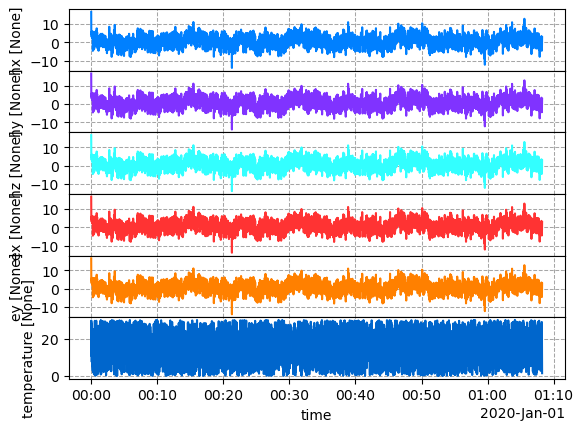

In [11]:
run_plot = run.plot()

## Resample

Resampling is a common method when working with data.  There are a few methods including

| Method | Description |
|--------|-------------|
| `decimate` | classic decimation: apply an anti-alias window then down sample by up to a factor of 8, if more are required repeat |
| `resample` | no anti-alias filter just simply pick samples at the new sample rate |
| `resample_poly` | upsampled, an FIR zero-phase low pass filter is applied then downsampled, efficient and most accurate **preferred method** |

<div class="alert alert-block alert-info">
<b>Note:</b> The recommended method is resample_poly which is more accurate as it does not assume a periodic signal.
</div>
     

In [9]:
resample_run = run.resample_poly(.25)
resample_run

2025-09-24T21:49:36.483500-0700 | WARNING | mth5.timeseries.run_ts | validate_metadata | end time of dataset 2020-01-01T01:08:12+00:00 does not match metadata end 2020-01-01T01:08:15+00:00 updating metatdata value to 2020-01-01T01:08:12+00:00
2025-09-24T21:49:36.485022-0700 | CRITICAL | mth5.timeseries.run_ts | validate_metadata | sample rate of dataset 0.0 does not match metadata sample rate 0.25 updating metatdata value to 0.0


RunTS Summary:
	Survey:      0
	Station:     mt001
	Run:         001
	Start:       2020-01-01T00:00:00+00:00
	End:         2020-01-01T01:08:12+00:00
	Sample Rate: 0.0
	Components:  ['hx', 'hy', 'hz', 'ex', 'ey', 'temperature']

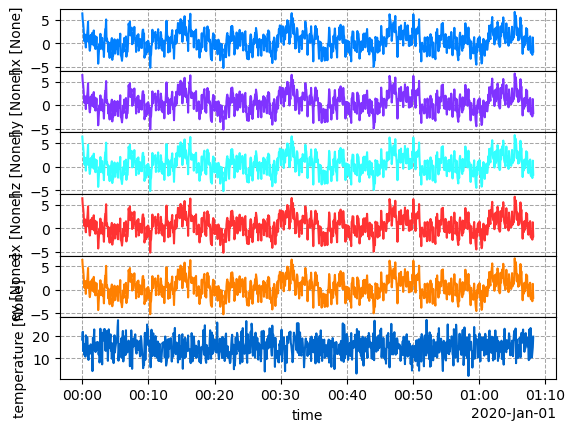

In [12]:
resample_plot = resample_run.plot()

## Calibration

a `RunTS` object can also be calibrate, it is a convenience function that calls `remove_instrument_response` on each channel.  

See Example 5 for a working example.

```
calibrated_run = run_ts_object.calibrate()
```